# AFFECTV Facial Affect Recognition
## Members
- DICHOSO, Aaron Gabrielle C.
- NATIVIDAD, Josh Austin Mikhail T.
- RAZON, Luis Miguel Antonio B.

# AffectNet
**Dataset Description** (from [link](https://paperswithcode.com/dataset/affectnet))\
AffectNet is a large facial expression dataset with around 0.4 million images manually labeled for the presence of eight (neutral, happy, angry, sad, fear, surprise, disgust, contempt) facial expressions along with the intensity of valence and arousal.

This dataset retrieved was already pre-processed by [Noam Segal](https://www.kaggle.com/noamsegal) for the purpose of machine learning. All images were reduced to 96 x 96 pixels, and cropped to the face. Some monochromatic images were removed through the use of Principal Component Analysis.

**Notebook Description**\
This notebook utilizes the AffectNet Dataset to create a model focused on the recognition of four emotions (happy, sad, angry, and neutral) based on the given facial expression features extracted by the OpenCV library.

# Libraries
These libraries were used in the development of this notebook.

In [18]:
!pip install opencv-python
!pip install --upgrade pip
!pip install mtcnn
!pip install mediapipe
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import statistics
from mtcnn import MTCNN
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np







  Using cached pip-24.0-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\Luis\anaconda3\python.exe -m pip install --upgrade pip


'wget' is not recognized as an internal or external command,
operable program or batch file.


# Data Import and Visualization

The file `labels.csv` contain metadata about the dataset, containing the columns `pth`, `label`, and `relFCs`.

- **pth**: Path of the image file
- **label**: emotion label of the image
- **relFCs**: Principal Component Analysis Percentage

Examples of images that will be used in this notebook can be seen in the code block below.

In [19]:
faces_df = pd.read_csv('./dataset/archive/labels.csv')
faces_df

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


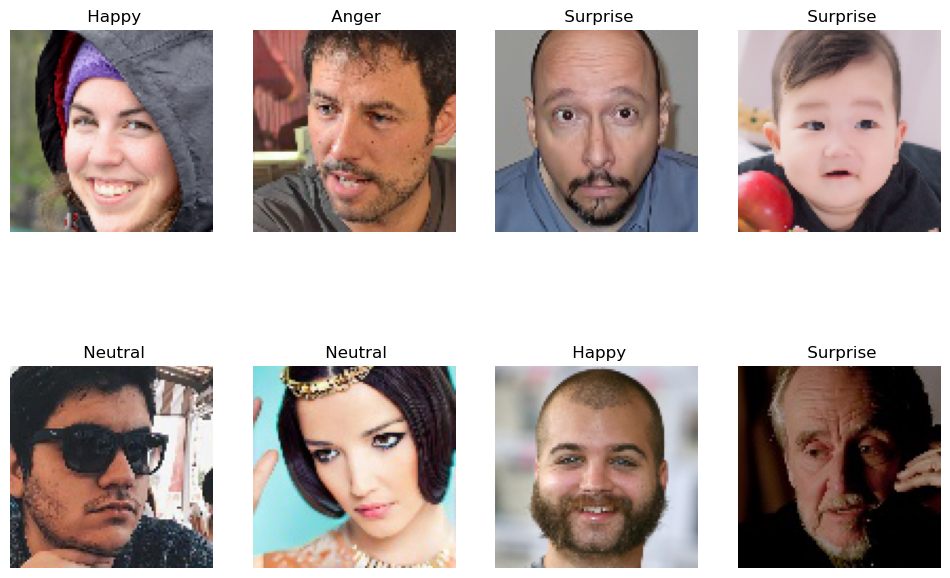

In [20]:
base_path = "./dataset/archive/"
random_images = []
def render_image(img_path, dataframe):
    pth = dataframe.iloc[img_path, 1]
    image_path = base_path + pth
    img = mpimg.imread(image_path)
    return img, dataframe.iloc[img_path, 2].title(), pth  # returns the img + label
# Display 8 random images from the dataset
i = 8
random_images = [(randint(1, faces_df.shape[0])) for x in range(i)]
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title, pth = render_image(random_images[i], faces_df)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f" {title}")
    axes[row, col].axis("off")

# Data Cleaning

## Removing Unneeded Emotions

Before performing other cleaning operations, the dataframe reference should be reduced to only the four emotions specified, to remove unecessary checking on the other emotions that won't be used in training the model.

In [21]:
#Step 1: Remove other emotions except from Happy, Sad, Anger, Neutral
emotions = ['happy', 'sad', 'anger', 'neutral']
init_size = faces_df.shape[0]

faces_df = faces_df.loc[faces_df['label'].isin(emotions)]

print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")
faces_df

Before: 28175
After: 13800


,Unnamed: 0,pth,label,relFCs
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
4,4,anger/image0000106.jpg,anger,0.849108
5,5,anger/image0000132.jpg,anger,0.819448
6,6,anger/image0000138.jpg,anger,0.852052
...,...,...,...,...
28141,28141,surprise/image0034852.jpg,neutral,0.695162
28164,28164,surprise/image0034931.jpg,happy,0.872834
28165,28165,surprise/image0034939.jpg,neutral,0.882535
28166,28166,surprise/image0034946.jpg,happy,0.794207


<function matplotlib.pyplot.show(close=None, block=None)>

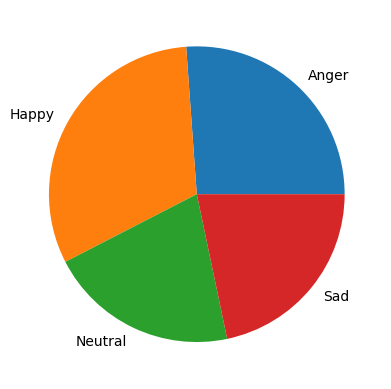

In [22]:
sum_df = faces_df[['pth', 'label']].groupby(['label']).count()
sum_df.rename(columns={'pth':'sum'}, inplace=True)
plt.pie(sum_df['sum'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show

In [23]:
sum_df

,sum
label,
anger,3608
happy,4336
neutral,2861
sad,2995


## Essential Data Cleaning

Once the dataframe has been specified to the needed emotion labels, we can start with the essential data cleaning of removing duplicate and missing values; howver, based on the results, there were none.

In [24]:
#Step 2: Essential Cleaning

#Duplicate Values
init_size = faces_df.shape[0]
faces_df = faces_df.drop_duplicates()
print("Duplicate Values")
print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")

#Missing Values
faces_df = faces_df.dropna()
print("Missing Values")
print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")


Duplicate Values
Before: 13800
After: 13800
Missing Values
Before: 13800
After: 13800


## Identifying proper labels from mismatch
It can be seen that many entries are mismatched, where the label of the given image is stored in the wrong folder, which can be observed in the list below.

Upon further inspection, most faces found in the list of conflicts had an impression of an emotion closer to its `label` attribute, compared its file path.

In [25]:
#Step 3: Identify path-label mismatch entries
mismatch_df = faces_df.loc[faces_df['pth'].str.split('/').str[0] != faces_df['label']]
mismatch_df

,Unnamed: 0,pth,label,relFCs
15,15,anger/image0000356.jpg,sad,0.821846
23,23,anger/image0000441.jpg,sad,0.792900
30,30,anger/image0000690.jpg,sad,0.853798
43,43,anger/image0000996.jpg,sad,0.793992
58,58,anger/image0001283.jpg,sad,0.737012
...,...,...,...,...
28141,28141,surprise/image0034852.jpg,neutral,0.695162
28164,28164,surprise/image0034931.jpg,happy,0.872834
28165,28165,surprise/image0034939.jpg,neutral,0.882535
28166,28166,surprise/image0034946.jpg,happy,0.794207


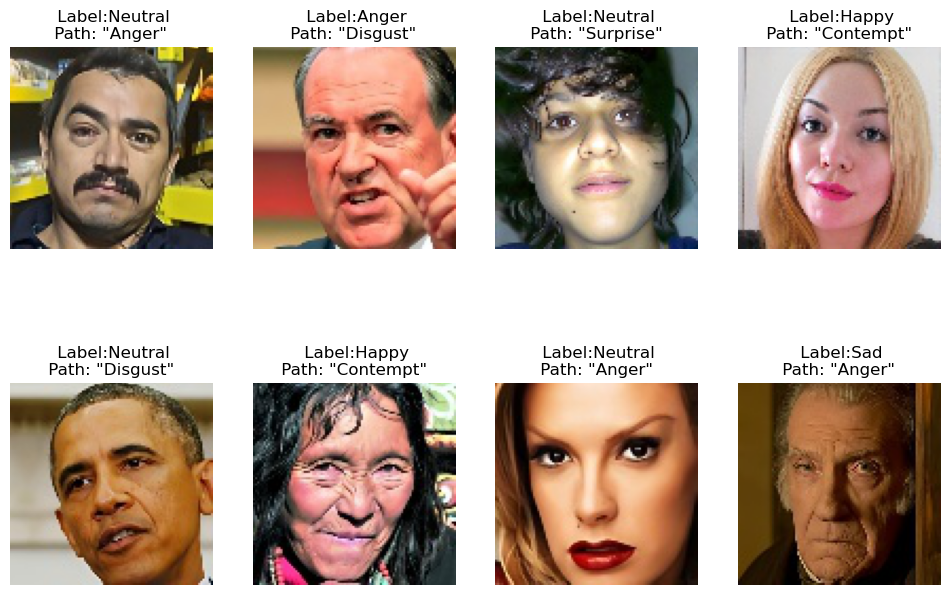

In [26]:
#Visualizations of the images with the conflicted path and label

# Display 8 random images from the dataset
i = 8
random_images = [(randint(1, mismatch_df.shape[0])) for x in range(i)]
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title, path = render_image(random_images[i],mismatch_df)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f" Label:{title}\n Path: \"{path.split('/')[0].title()}\" ")
    axes[row, col].axis("off")

based on these results, we conclude that the label of all images will follow the `label` attribute given in the dataframe, instead of `pth`.

## Removing Faces Oriented Sideways

### Model Test

In [27]:
#MTCNN has a parameter called min_face_size where if it is lower it can detect faces that it wasnt able to detect
#by default at the cost of the accuracy of the points
detector = MTCNN(min_face_size = 30) # Model Used (https://github.com/ipazc/mtcnn)

In [28]:
"""
Function that marks faces based on an array containing the output values of MTCNN to draw a box and mark the points
the faces (for display)
Input: cv2 object, faces array 
Output: image with marks
"""
def mark_faces(cv2_image, faces):
    if len(faces) <= 0:
        return cv2_image #sentinel value
    for face in faces:
        box = face['box']
        conf = face['confidence']
        print("confidence: ", conf)
        x, y, w, h = box[0], box[1], box[2], box[3]
        color = (0, 0,255)
            
        cv2.putText(cv2_image, str(round(conf,2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=1)
        cv2.rectangle(cv2_image, (x, y), (x+w, y+h) , color, 1)

        cv2.circle(cv2_image, face['keypoints']['nose'], 1, color, -1)
        cv2.circle(cv2_image, face['keypoints']['left_eye'], 1, color, -1)
        cv2.circle(cv2_image, face['keypoints']['right_eye'], 1, color, -1)
    
    return cv2_image
"""
Function that calculates the distances of:
- right eye to left eye
- left eye to nose
- right eye to nose
- average distance of righy eye and left eye to the nose
based on the locations indicated in a entry in the faces array and returns the orientation of the head in the image

Input: faces array
Output: String dictating the orientation ("FRONT", "SIDEWAYS", "UPWARDS", "-1") and -1 as the sentinel value
if there are no faces 
detected.

"""
def get_distances(faces):
    if len(faces) <= 0:
        return "NONE"
    for face in faces:
        distance_reye_nose = math.dist(face['keypoints']['right_eye'], face['keypoints']['nose'])
        distance_leye_nose = math.dist(face['keypoints']['left_eye'], face['keypoints']['nose'])
        distance_leye_reye = math.dist(face['keypoints']['left_eye'], face['keypoints']['right_eye'])
        average_distance_eyes_nose = statistics.mean([distance_leye_nose,distance_reye_nose])

        #Checking and removing images if the subject is looking sideways or upwards by calculating face distance.
        if abs(distance_leye_nose - distance_reye_nose) > 5: #threshold value, derived from pure intuition
            return "SIDEWAYS"
        elif average_distance_eyes_nose < 15: #threshold value yet again
            return "UPWARDS"
        else:
           return "FRONT"

1/1 [==============================] - 0s 105ms/step
confidence:  0.9708724617958069
FRONT
1/1 [==============================] - 0s 19ms/step
confidence:  0.9976978898048401
SIDEWAYS
1/1 [==============================] - 0s 19ms/step
confidence:  0.9886873960494995
FRONT
1/1 [==============================] - 0s 18ms/step
confidence:  0.9571421146392822
FRONT
1/1 [==============================] - 0s 18ms/step
confidence:  0.9952002763748169
FRONT


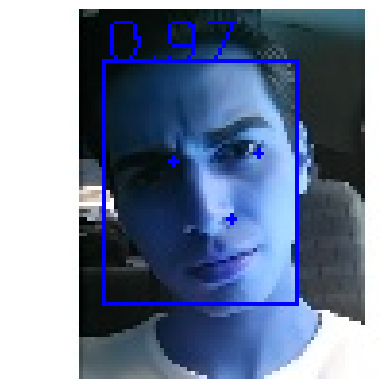

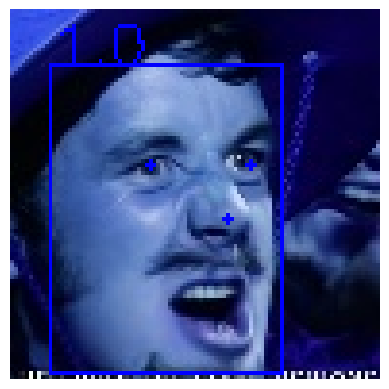

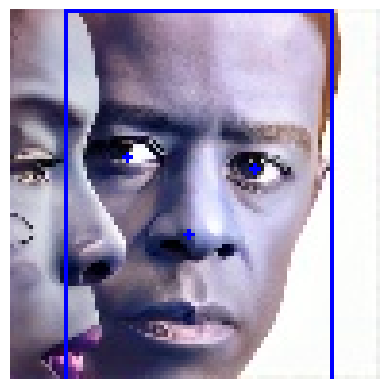

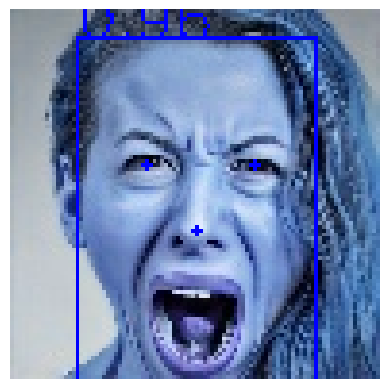

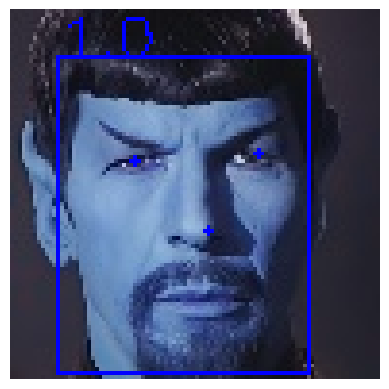

In [29]:
#Check accuracy of the model and calculations

i = 0

#Generate a random sample of images from the DataFrame
#faces_df = faces_df.sample(frac=1)

#Iterate through the DataFrame 
for idx, row in faces_df.iterrows():
    face_img = cv2.imread(base_path + row['pth'])
    faces = detector.detect_faces(face_img)

    face_img = mark_faces(face_img, faces)
    print(get_distances(faces))
    plt.figure()
    plt.imshow(face_img)
    plt.axis('off')
    #print(f"degree: {degree}")
    i+=1
    if i == 5:
        break
    

### Removal Process

In [ ]:
#Removing images flagged as not "front"
#Note: itertuples might improve performance

#adds a column to the dataframe to indicate if a face is detected, will be useful later for detecting outliers
faces_df['faceDetected'] = True
faces_df['numFaces'] = 0

prev_size = faces_df.shape[0]
for idx, row in faces_df.iterrows():
    face_img = cv2.imread(base_path + row['pth'])
    faces = detector.detect_faces(face_img)
    
    faces_df.at[idx, 'numFaces'] = len(faces)

    #Check if not front and none (checking of none will be done manually)
    if get_distances(faces) != "FRONT" and get_distances(faces) != "NONE":
        faces_df.drop(index=idx, inplace=True)
    
    #If no face detected, set faceDetected to False
    if len(faces) <= 0:
        faces_df.at[idx, 'faceDetected'] = False
    

print(f"{prev_size} => {faces_df.shape[0]}")



Due to the amount of time it takes to perform the process above, the resulting dataframe is saved to `cleaned_faces.csv`. This can then be used to open the result without having to run the data cleaning process again, saving time.

In [14]:
faces_df.to_csv('cleaned_faces.csv', index=False, header=True, encoding='utf-8')

In [15]:
#group by label
sum_df = faces_df[['pth', 'label']].groupby(['label']).count()
sum_df

,pth
label,
anger,2504
happy,3452
neutral,1872
sad,2022


In [41]:
cleaned_faces_df = pd.read_csv('cleaned_faces.csv')
cleaned_faces_df

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces
0,1,anger/image0000060.jpg,anger,0.852311,True,1
1,4,anger/image0000106.jpg,anger,0.849108,True,1
2,5,anger/image0000132.jpg,anger,0.819448,True,1
3,6,anger/image0000138.jpg,anger,0.852052,True,1
4,8,anger/image0000195.jpg,anger,0.823133,True,1
...,...,...,...,...,...,...
9845,28135,surprise/image0034829.jpg,happy,0.807797,True,1
9846,28136,surprise/image0034831.jpg,neutral,0.839804,True,1
9847,28164,surprise/image0034931.jpg,happy,0.872834,True,1
9848,28165,surprise/image0034939.jpg,neutral,0.882535,True,1


## Removing multiple faces

Since the model was set to detect all faces in an image, there are instances where multiple faces are detected. To ensure that the model is trained properly, we will remove these images from the dataset.

In [42]:
#Check if there is a row that numFaces > 1
cleaned_faces_df[cleaned_faces_df['numFaces'] > 1]
print("Before: ", cleaned_faces_df.shape[0])

for idx, row in cleaned_faces_df.iterrows():
    if row['numFaces'] > 1:
        cleaned_faces_df.drop(index=idx, inplace=True)
        

print("After: ", cleaned_faces_df.shape[0])


Before:  9850
After:  9844


## Manual removal of images without faces detected

There are some images wherein the model was also unable to detect a face, this may be due to obstruction or the image showing an incomplete face. We will also remove these images from the dataset.

In [43]:
no_face_df = cleaned_faces_df.loc[cleaned_faces_df['faceDetected'] == False]
print(f"Images with no face detected: {no_face_df.shape[0]}")
print(f"Before: {cleaned_faces_df.shape[0]}")
cleaned_faces_df = cleaned_faces_df.loc[cleaned_faces_df['faceDetected'] == True]
print(f"After: {cleaned_faces_df.shape[0]}")


Images with no face detected: 738
Before: 9844
After: 9106


# Data Modeling

## Extracting Facial Landmarks

After the dataset has been processed, it is now possible to extract the facial landmarks that will be used by a machine learning model for the prediction of the given emotion labels.

### Model Used: [Mediapipe Facial Landmark Detection Model](https://developers.google.com/mediapipe/solutions/vision/face_landmarker)
The Mediapipe Face Landmarker uses machine learning models to create a face mesh that outputs an estimate of 478 3-dimensional face landmarks. The large amount of facial landmarks generated by this model serve as rich representations of the facial expressions. It is able to capture the key points and positions of each part of the face, such as the eyebrows, eyes, nose, and mouth, and even the small details such as the forehead, cheeks, and jaw, allowing the model to provide a comprehensive analysis of facial expressions.

## Facial Landmark Model Testing

Before extracting the facial landmarks of every face in the dataset, the model was first tested on an image not part of the database.

In [44]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.5743138790130615, y=0.6889077425003052, z=-0.0757405161857605, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5861771702766418, y=0.6081040501594543, z=-0.11635051667690277, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5806379318237305, y=0.6360802054405212, z=-0.06825906038284302, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5728011727333069, y=0.5384976863861084, z=-0.07820826768875122, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5886233448982239, y=0.5850725769996643, z=-0.12065678834915161, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5904492139816284, y=0.5581714510917664, z=-0.10794224590063095, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5934493541717529, y=0.49504899978637695, z=-0.0367915965616703, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.43090513348579407, y=0.47988396883010864, z=0.03688709810376167, visibility=0.0, presence=0.0), NormalizedLandmark

(-0.5, 942.5, 942.5, -0.5)

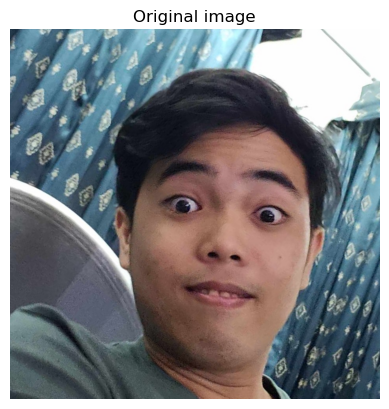

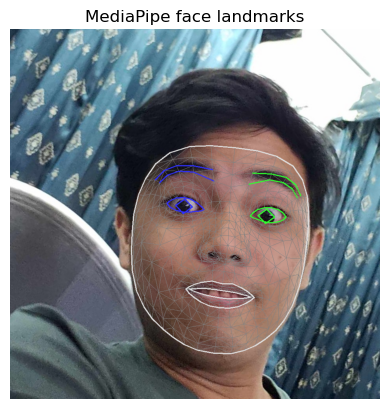

In [45]:
#Model Setup
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)

#Test the model
detector2 = vision.FaceLandmarker.create_from_options(options)               
image = mp.Image.create_from_file("./mediapipe_test.jpg")
detection_result = detector2.detect(image) #this is the line

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print(detection_result)
#original image
plt.figure()
plt.imshow(image.numpy_view())
plt.title('Original image')
plt.axis('off')
#annotated image
plt.figure()
plt.imshow(annotated_image)
plt.title('MediaPipe face landmarks')
plt.axis('off')

#display the resulting coordinates of each landmark


In [46]:
print("Obtained Landmarks")
print(detection_result.face_landmarks[0][0].x, detection_result.face_landmarks[0][0].y, detection_result.face_landmarks[0][0].z)
print('Count: ', len(detection_result.face_landmarks[0]))

Obtained Landmarks
0.5743138790130615 0.6889077425003052 -0.0757405161857605
Count:  478


## Appending Facial Landmark Values in `cleaned_faces_df`

In [47]:
i = 0
# add a 'landmarks' column to the dataframe
cleaned_faces_df['landmarks'] = None
for idx, row in cleaned_faces_df.iterrows():
    face_img = mp.Image.create_from_file(base_path + row['pth'])
    detection_result = detector2.detect(face_img)
    
    #if no face detected, drop the row
    if len(detection_result.face_landmarks) <= 0:
        cleaned_faces_df.drop(index=idx, inplace=True)
        continue
    
    cleaned_faces_df.at[idx, 'landmarks'] = detection_result
    
    i+=1
    print('Face #', i)
    
    

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df['landmarks'] = None


Face # 1
Face # 2
Face # 3
Face # 4
Face # 5
Face # 6
Face # 7
Face # 8
Face # 9
Face # 10
Face # 11
Face # 12
Face # 13
Face # 14
Face # 15
Face # 16
Face # 17
Face # 18
Face # 19
Face # 20
Face # 21
Face # 22
Face # 23
Face # 24
Face # 25
Face # 26
Face # 27
Face # 28
Face # 29
Face # 30
Face # 31
Face # 32
Face # 33
Face # 34
Face # 35
Face # 36
Face # 37
Face # 38
Face # 39
Face # 40
Face # 41
Face # 42
Face # 43
Face # 44
Face # 45
Face # 46
Face # 47
Face # 48
Face # 49
Face # 50
Face # 51
Face # 52
Face # 53
Face # 54
Face # 55
Face # 56
Face # 57
Face # 58
Face # 59
Face # 60
Face # 61
Face # 62
Face # 63
Face # 64
Face # 65
Face # 66
Face # 67
Face # 68
Face # 69
Face # 70
Face # 71
Face # 72
Face # 73
Face # 74
Face # 75
Face # 76
Face # 77
Face # 78
Face # 79
Face # 80
Face # 81
Face # 82
Face # 83
Face # 84
Face # 85
Face # 86
Face # 87
Face # 88
Face # 89
Face # 90
Face # 91
Face # 92
Face # 93
Face # 94
Face # 95
Face # 96
Face # 97
Face # 98
Face # 99
Face # 100
Face # 1

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 301
Face # 302
Face # 303
Face # 304
Face # 305
Face # 306
Face # 307
Face # 308
Face # 309
Face # 310
Face # 311
Face # 312
Face # 313
Face # 314
Face # 315
Face # 316
Face # 317
Face # 318
Face # 319
Face # 320
Face # 321
Face # 322
Face # 323
Face # 324
Face # 325
Face # 326
Face # 327
Face # 328
Face # 329
Face # 330
Face # 331
Face # 332
Face # 333
Face # 334
Face # 335
Face # 336
Face # 337
Face # 338
Face # 339
Face # 340
Face # 341


C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 342
Face # 343
Face # 344
Face # 345
Face # 346
Face # 347
Face # 348
Face # 349
Face # 350
Face # 351
Face # 352
Face # 353
Face # 354
Face # 355
Face # 356
Face # 357
Face # 358
Face # 359
Face # 360
Face # 361
Face # 362
Face # 363
Face # 364
Face # 365
Face # 366
Face # 367
Face # 368
Face # 369
Face # 370
Face # 371
Face # 372
Face # 373
Face # 374
Face # 375
Face # 376
Face # 377
Face # 378
Face # 379
Face # 380
Face # 381
Face # 382
Face # 383
Face # 384
Face # 385
Face # 386
Face # 387
Face # 388
Face # 389
Face # 390
Face # 391
Face # 392
Face # 393
Face # 394
Face # 395
Face # 396
Face # 397
Face # 398
Face # 399
Face # 400
Face # 401
Face # 402
Face # 403
Face # 404
Face # 405
Face # 406
Face # 407
Face # 408
Face # 409
Face # 410
Face # 411
Face # 412
Face # 413
Face # 414
Face # 415
Face # 416
Face # 417
Face # 418
Face # 419
Face # 420
Face # 421
Face # 422
Face # 423
Face # 424
Face # 425
Face # 426
Face # 427
Face # 428
Face # 429
Face # 430
Face # 431
Face # 432

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 582
Face # 583
Face # 584
Face # 585
Face # 586
Face # 587
Face # 588
Face # 589
Face # 590
Face # 591
Face # 592
Face # 593
Face # 594
Face # 595
Face # 596
Face # 597
Face # 598
Face # 599
Face # 600
Face # 601
Face # 602
Face # 603
Face # 604
Face # 605
Face # 606
Face # 607
Face # 608
Face # 609
Face # 610
Face # 611
Face # 612
Face # 613
Face # 614
Face # 615
Face # 616
Face # 617
Face # 618
Face # 619
Face # 620
Face # 621
Face # 622
Face # 623
Face # 624
Face # 625
Face # 626
Face # 627
Face # 628
Face # 629
Face # 630
Face # 631
Face # 632
Face # 633
Face # 634
Face # 635
Face # 636
Face # 637
Face # 638
Face # 639
Face # 640
Face # 641
Face # 642
Face # 643
Face # 644
Face # 645
Face # 646
Face # 647
Face # 648
Face # 649


C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 650
Face # 651
Face # 652
Face # 653
Face # 654
Face # 655
Face # 656
Face # 657
Face # 658
Face # 659
Face # 660
Face # 661
Face # 662
Face # 663
Face # 664
Face # 665
Face # 666
Face # 667
Face # 668
Face # 669
Face # 670
Face # 671
Face # 672
Face # 673
Face # 674
Face # 675
Face # 676
Face # 677
Face # 678
Face # 679
Face # 680
Face # 681
Face # 682
Face # 683
Face # 684
Face # 685
Face # 686
Face # 687
Face # 688
Face # 689
Face # 690
Face # 691
Face # 692
Face # 693
Face # 694
Face # 695
Face # 696
Face # 697
Face # 698
Face # 699
Face # 700
Face # 701
Face # 702
Face # 703
Face # 704
Face # 705
Face # 706
Face # 707
Face # 708
Face # 709
Face # 710
Face # 711
Face # 712
Face # 713
Face # 714
Face # 715
Face # 716
Face # 717
Face # 718
Face # 719
Face # 720
Face # 721
Face # 722
Face # 723
Face # 724
Face # 725
Face # 726
Face # 727
Face # 728
Face # 729
Face # 730
Face # 731
Face # 732
Face # 733
Face # 734
Face # 735
Face # 736
Face # 737
Face # 738
Face # 739
Face # 740

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 922
Face # 923
Face # 924
Face # 925
Face # 926
Face # 927
Face # 928
Face # 929
Face # 930
Face # 931
Face # 932
Face # 933
Face # 934
Face # 935
Face # 936
Face # 937
Face # 938
Face # 939
Face # 940
Face # 941
Face # 942
Face # 943
Face # 944
Face # 945
Face # 946
Face # 947
Face # 948
Face # 949
Face # 950
Face # 951
Face # 952
Face # 953
Face # 954
Face # 955
Face # 956
Face # 957
Face # 958
Face # 959
Face # 960
Face # 961
Face # 962
Face # 963
Face # 964
Face # 965
Face # 966
Face # 967
Face # 968
Face # 969
Face # 970
Face # 971
Face # 972
Face # 973
Face # 974
Face # 975
Face # 976
Face # 977
Face # 978
Face # 979
Face # 980
Face # 981
Face # 982
Face # 983
Face # 984
Face # 985
Face # 986
Face # 987
Face # 988
Face # 989
Face # 990
Face # 991
Face # 992
Face # 993
Face # 994
Face # 995
Face # 996
Face # 997
Face # 998
Face # 999
Face # 1000
Face # 1001
Face # 1002
Face # 1003
Face # 1004
Face # 1005
Face # 1006
Face # 1007
Face # 1008
Face # 1009
Face # 1010
Face # 101

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 1104
Face # 1105
Face # 1106
Face # 1107
Face # 1108
Face # 1109
Face # 1110
Face # 1111
Face # 1112
Face # 1113
Face # 1114
Face # 1115
Face # 1116
Face # 1117
Face # 1118
Face # 1119
Face # 1120
Face # 1121
Face # 1122
Face # 1123
Face # 1124
Face # 1125
Face # 1126
Face # 1127
Face # 1128
Face # 1129
Face # 1130
Face # 1131
Face # 1132
Face # 1133
Face # 1134
Face # 1135
Face # 1136
Face # 1137
Face # 1138
Face # 1139
Face # 1140
Face # 1141
Face # 1142
Face # 1143
Face # 1144
Face # 1145
Face # 1146
Face # 1147
Face # 1148
Face # 1149
Face # 1150
Face # 1151
Face # 1152
Face # 1153
Face # 1154
Face # 1155
Face # 1156
Face # 1157
Face # 1158
Face # 1159
Face # 1160
Face # 1161
Face # 1162
Face # 1163
Face # 1164
Face # 1165
Face # 1166
Face # 1167
Face # 1168
Face # 1169
Face # 1170
Face # 1171
Face # 1172
Face # 1173
Face # 1174
Face # 1175
Face # 1176
Face # 1177
Face # 1178
Face # 1179
Face # 1180
Face # 1181
Face # 1182
Face # 1183
Face # 1184
Face # 1185
Face # 1186
Face

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 1234
Face # 1235
Face # 1236
Face # 1237
Face # 1238
Face # 1239
Face # 1240
Face # 1241
Face # 1242
Face # 1243
Face # 1244
Face # 1245
Face # 1246
Face # 1247
Face # 1248
Face # 1249
Face # 1250
Face # 1251
Face # 1252
Face # 1253
Face # 1254
Face # 1255
Face # 1256
Face # 1257
Face # 1258
Face # 1259
Face # 1260
Face # 1261
Face # 1262
Face # 1263
Face # 1264
Face # 1265
Face # 1266
Face # 1267
Face # 1268
Face # 1269
Face # 1270
Face # 1271
Face # 1272
Face # 1273
Face # 1274
Face # 1275
Face # 1276
Face # 1277
Face # 1278
Face # 1279
Face # 1280
Face # 1281
Face # 1282
Face # 1283
Face # 1284
Face # 1285
Face # 1286
Face # 1287
Face # 1288


C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 1289
Face # 1290
Face # 1291
Face # 1292
Face # 1293
Face # 1294
Face # 1295
Face # 1296
Face # 1297
Face # 1298
Face # 1299
Face # 1300
Face # 1301
Face # 1302
Face # 1303
Face # 1304
Face # 1305
Face # 1306
Face # 1307
Face # 1308
Face # 1309
Face # 1310
Face # 1311
Face # 1312
Face # 1313
Face # 1314
Face # 1315
Face # 1316
Face # 1317
Face # 1318
Face # 1319
Face # 1320
Face # 1321
Face # 1322
Face # 1323
Face # 1324
Face # 1325
Face # 1326
Face # 1327
Face # 1328
Face # 1329
Face # 1330
Face # 1331
Face # 1332
Face # 1333
Face # 1334
Face # 1335
Face # 1336
Face # 1337
Face # 1338
Face # 1339
Face # 1340
Face # 1341
Face # 1342
Face # 1343
Face # 1344
Face # 1345
Face # 1346
Face # 1347
Face # 1348
Face # 1349
Face # 1350
Face # 1351
Face # 1352
Face # 1353
Face # 1354
Face # 1355
Face # 1356
Face # 1357
Face # 1358
Face # 1359
Face # 1360
Face # 1361
Face # 1362
Face # 1363
Face # 1364
Face # 1365
Face # 1366
Face # 1367
Face # 1368
Face # 1369
Face # 1370
Face # 1371
Face

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 1458
Face # 1459
Face # 1460
Face # 1461
Face # 1462
Face # 1463
Face # 1464
Face # 1465
Face # 1466
Face # 1467
Face # 1468
Face # 1469
Face # 1470
Face # 1471
Face # 1472
Face # 1473
Face # 1474
Face # 1475
Face # 1476
Face # 1477
Face # 1478
Face # 1479
Face # 1480
Face # 1481
Face # 1482
Face # 1483
Face # 1484
Face # 1485
Face # 1486
Face # 1487
Face # 1488
Face # 1489
Face # 1490
Face # 1491
Face # 1492
Face # 1493
Face # 1494
Face # 1495
Face # 1496
Face # 1497
Face # 1498
Face # 1499
Face # 1500
Face # 1501
Face # 1502
Face # 1503
Face # 1504
Face # 1505
Face # 1506
Face # 1507
Face # 1508
Face # 1509
Face # 1510
Face # 1511
Face # 1512
Face # 1513
Face # 1514
Face # 1515
Face # 1516
Face # 1517
Face # 1518
Face # 1519
Face # 1520
Face # 1521
Face # 1522
Face # 1523
Face # 1524
Face # 1525
Face # 1526
Face # 1527
Face # 1528
Face # 1529
Face # 1530
Face # 1531
Face # 1532
Face # 1533
Face # 1534
Face # 1535
Face # 1536
Face # 1537
Face # 1538
Face # 1539
Face # 1540
Face

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 2956
Face # 2957
Face # 2958
Face # 2959
Face # 2960
Face # 2961
Face # 2962
Face # 2963
Face # 2964
Face # 2965
Face # 2966
Face # 2967
Face # 2968
Face # 2969
Face # 2970
Face # 2971
Face # 2972
Face # 2973
Face # 2974
Face # 2975
Face # 2976
Face # 2977
Face # 2978
Face # 2979
Face # 2980
Face # 2981
Face # 2982
Face # 2983
Face # 2984
Face # 2985
Face # 2986
Face # 2987
Face # 2988
Face # 2989
Face # 2990
Face # 2991
Face # 2992
Face # 2993
Face # 2994
Face # 2995
Face # 2996
Face # 2997
Face # 2998
Face # 2999
Face # 3000
Face # 3001
Face # 3002
Face # 3003
Face # 3004
Face # 3005
Face # 3006
Face # 3007
Face # 3008
Face # 3009
Face # 3010
Face # 3011
Face # 3012
Face # 3013
Face # 3014
Face # 3015
Face # 3016
Face # 3017
Face # 3018
Face # 3019
Face # 3020
Face # 3021
Face # 3022
Face # 3023
Face # 3024
Face # 3025
Face # 3026
Face # 3027
Face # 3028
Face # 3029
Face # 3030
Face # 3031
Face # 3032
Face # 3033
Face # 3034
Face # 3035
Face # 3036
Face # 3037
Face # 3038
Face

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 7850
Face # 7851
Face # 7852
Face # 7853
Face # 7854
Face # 7855
Face # 7856
Face # 7857
Face # 7858
Face # 7859
Face # 7860
Face # 7861
Face # 7862
Face # 7863
Face # 7864
Face # 7865
Face # 7866
Face # 7867
Face # 7868
Face # 7869
Face # 7870
Face # 7871
Face # 7872
Face # 7873
Face # 7874
Face # 7875
Face # 7876
Face # 7877
Face # 7878
Face # 7879
Face # 7880
Face # 7881
Face # 7882
Face # 7883
Face # 7884
Face # 7885
Face # 7886
Face # 7887
Face # 7888
Face # 7889
Face # 7890
Face # 7891
Face # 7892
Face # 7893
Face # 7894
Face # 7895
Face # 7896
Face # 7897
Face # 7898
Face # 7899
Face # 7900
Face # 7901
Face # 7902
Face # 7903
Face # 7904
Face # 7905
Face # 7906
Face # 7907
Face # 7908
Face # 7909
Face # 7910
Face # 7911
Face # 7912
Face # 7913
Face # 7914
Face # 7915
Face # 7916
Face # 7917
Face # 7918
Face # 7919
Face # 7920
Face # 7921
Face # 7922
Face # 7923
Face # 7924
Face # 7925
Face # 7926
Face # 7927
Face # 7928
Face # 7929
Face # 7930
Face # 7931
Face # 7932
Face

C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)
C:\Users\Luis\AppData\Local\Temp\ipykernel_34368\3837966818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)


Face # 8092
Face # 8093
Face # 8094
Face # 8095
Face # 8096
Face # 8097
Face # 8098
Face # 8099
Face # 8100
Face # 8101
Face # 8102
Face # 8103
Face # 8104
Face # 8105
Face # 8106
Face # 8107
Face # 8108
Face # 8109
Face # 8110
Face # 8111
Face # 8112
Face # 8113
Face # 8114
Face # 8115
Face # 8116
Face # 8117
Face # 8118
Face # 8119
Face # 8120
Face # 8121
Face # 8122
Face # 8123
Face # 8124
Face # 8125
Face # 8126
Face # 8127
Face # 8128
Face # 8129
Face # 8130
Face # 8131
Face # 8132
Face # 8133
Face # 8134
Face # 8135
Face # 8136
Face # 8137
Face # 8138
Face # 8139
Face # 8140
Face # 8141
Face # 8142
Face # 8143
Face # 8144
Face # 8145
Face # 8146
Face # 8147
Face # 8148
Face # 8149
Face # 8150
Face # 8151
Face # 8152
Face # 8153
Face # 8154
Face # 8155
Face # 8156
Face # 8157
Face # 8158
Face # 8159
Face # 8160
Face # 8161
Face # 8162
Face # 8163
Face # 8164
Face # 8165
Face # 8166
Face # 8167
Face # 8168
Face # 8169
Face # 8170
Face # 8171
Face # 8172
Face # 8173
Face # 8174
Face

In [48]:
cleaned_faces_df.to_csv('cleaned_faces_with_landmarks.csv', index=False, header=True, encoding='utf-8')

### Landmark Validation

In [49]:
cleaned_faces_df 

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces,landmarks
0,1,anger/image0000060.jpg,anger,0.852311,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
1,4,anger/image0000106.jpg,anger,0.849108,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
2,5,anger/image0000132.jpg,anger,0.819448,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
3,6,anger/image0000138.jpg,anger,0.852052,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
4,8,anger/image0000195.jpg,anger,0.823133,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
...,...,...,...,...,...,...,...
9845,28135,surprise/image0034829.jpg,happy,0.807797,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
9846,28136,surprise/image0034831.jpg,neutral,0.839804,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
9847,28164,surprise/image0034931.jpg,happy,0.872834,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
9848,28165,surprise/image0034939.jpg,neutral,0.882535,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...


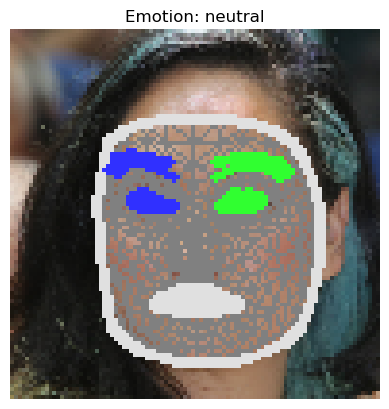

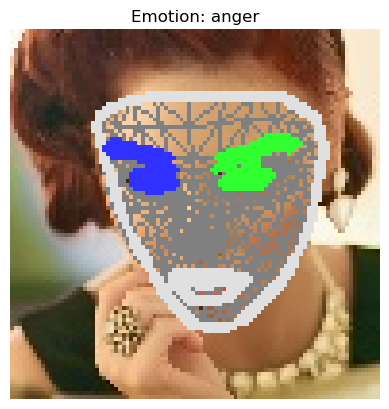

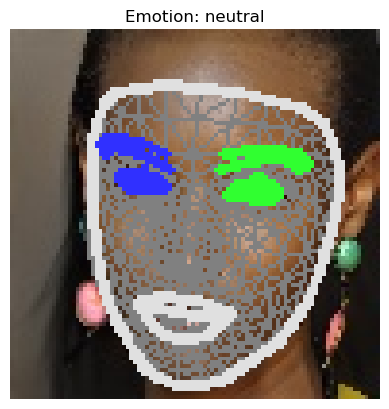

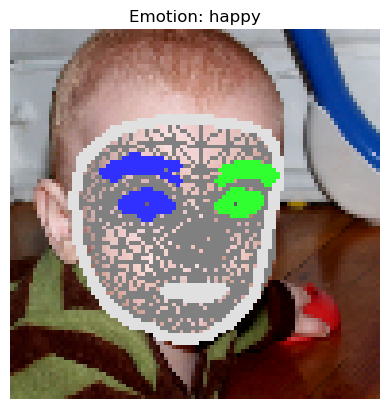

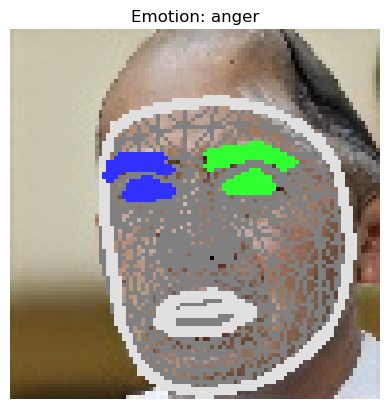

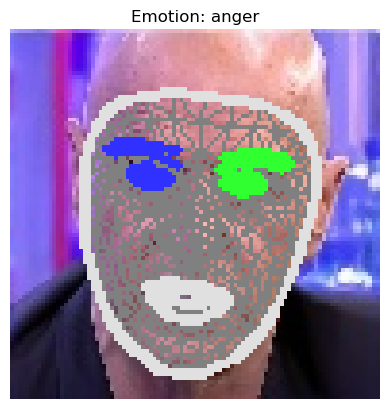

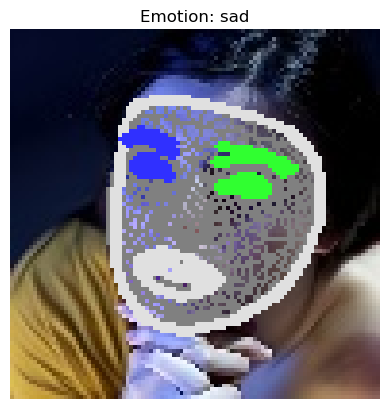

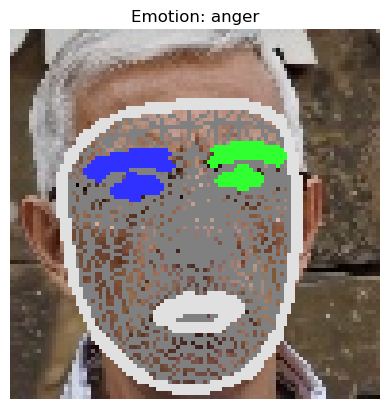

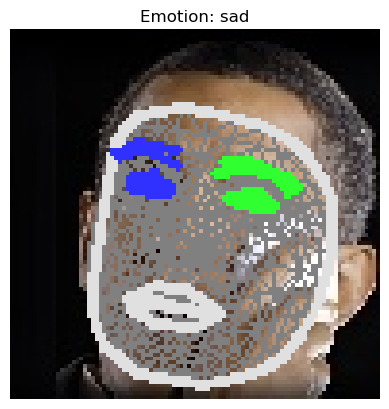

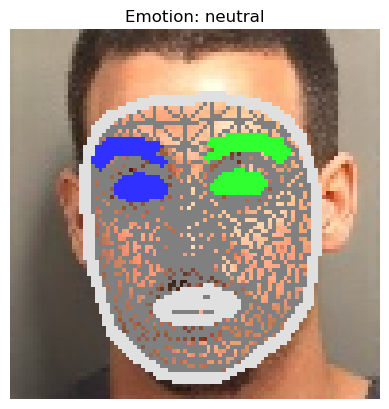

In [50]:
for idx, row in cleaned_faces_df.sample(10).iterrows():
    if row['faceDetected'] == False:
        continue
    face_img = mp.Image.create_from_file(base_path + row['pth'])
    detection_result = row['landmarks']
    annotated_image = draw_landmarks_on_image(face_img.numpy_view(), detection_result)
    plt.figure()
    plt.imshow(annotated_image)
    plt.axis('off')
    plt.title(f"Emotion: {row['label']}")

## Addressing label mismatch
As discussed previously, label mismatches were found in the dataset wherein the emotion present in the `label` attribute does not match the emotion presented in the `pth` attribute. To address this, we will duplicate the mismatched rows so that one row will contain the emotion present in the `pth` attribute in the `label` attribute, and the other row will contain the emotion present in the `label` attribute in the `label` attribute.

In [51]:
#Check mismatched labels again after cleaning
mismatch_df = cleaned_faces_df.loc[cleaned_faces_df['pth'].str.split('/').str[0] != cleaned_faces_df['label']]

print(f"Mismatched Path-Label: {mismatch_df.shape[0]}")
print(f"Before: {cleaned_faces_df.shape[0]}")
for idx, row in mismatch_df.iterrows():
    pth_emotion = row['pth'].split('/')[0]

    #find the row in cleaned_faces_df and deep copy
    cleaned_faces_row = cleaned_faces_df.loc[cleaned_faces_df['pth'] == row['pth']].copy(deep=True)
    cleaned_faces_row['label'] = pth_emotion

    #If the row is present, concat the new row with the changed value
    if cleaned_faces_row.shape[0] > 0:
        cleaned_faces_df = pd.concat([cleaned_faces_df, cleaned_faces_row])
        

print(f"After: {cleaned_faces_df.shape[0]}")

Mismatched Path-Label: 2758
Before: 9093
After: 11851


In [54]:
#Displays the rows with duplicate paths to prove code above works
cleaned_faces_df[cleaned_faces_df.duplicated(subset='pth', keep=False)].sort_values(by='pth').head(10)

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces,landmarks
11,23,anger/image0000441.jpg,sad,0.792900,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
11,23,anger/image0000441.jpg,anger,0.792900,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
16,30,anger/image0000690.jpg,anger,0.853798,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
16,30,anger/image0000690.jpg,sad,0.853798,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
33,66,anger/image0001453.jpg,neutral,0.815683,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
33,66,anger/image0001453.jpg,anger,0.815683,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
49,90,anger/image0001916.jpg,sad,0.818010,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
49,90,anger/image0001916.jpg,anger,0.818010,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
51,93,anger/image0001956.jpg,happy,0.877426,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
51,93,anger/image0001956.jpg,anger,0.877426,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...


## Oversampling
This will be used to oversample images according to the highest amount of images in an emotion label. This is needed so that during the training portion of the emotion recognition model, it's emotion recognition functionality may not be skewed favoring one emotion.

In [55]:
dict_df_emotions = {
    "happy" :  cleaned_faces_df[cleaned_faces_df['label'] == 'happy'],
    "sad" : cleaned_faces_df[cleaned_faces_df['label'] == 'sad'],
    "anger" : cleaned_faces_df[cleaned_faces_df['label'] == 'anger'],
    "neutral" : cleaned_faces_df[cleaned_faces_df['label'] == 'neutral']
}

dict_counts = {
    "happy" : dict_df_emotions['happy'].shape[0],
    "sad" : dict_df_emotions['sad'].shape[0],
    "anger" : dict_df_emotions['anger'].shape[0],
    "neutral" : dict_df_emotions['neutral'].shape[0]
}

dict_counts = dict(sorted(dict_counts.items(), key = lambda item : item[1],  reverse = True))
dict_counts

{'happy': 3394, 'neutral': 2513, 'anger': 2488, 'sad': 2178}

In [56]:
#Step 3: Get number of oversampled images needed for each emotion
highest_count = dict_counts[list(dict_counts)[0]]

print(highest_count)

oversampling_count = {
    "happy" : highest_count - dict_df_emotions['happy'].shape[0],
    "sad" : highest_count - dict_df_emotions['sad'].shape[0],
    "anger" : highest_count - dict_df_emotions['anger'].shape[0],
    "neutral" : highest_count - dict_df_emotions['neutral'].shape[0]
}

oversampling_count

3394


{'happy': 0, 'sad': 1216, 'anger': 906, 'neutral': 881}

In [57]:
#Step 4: for each emotion, generate new images according to oversampling count

for emotion in list(oversampling_count):
    print("=======!!!", emotion, oversampling_count[emotion],"!!!=======")
    max_range = dict_df_emotions[emotion].shape[0] - 1
    added_rows_df = pd.DataFrame()
    emotion_indices = []
    print(dict_df_emotions[emotion])
    print("====== INDEX:", max_range,"======")
    print(dict_df_emotions[emotion].iloc[max_range])
    for i in range(oversampling_count[emotion]):
        #Pick a random entry inside of the given emotion
        random_index = randint(0, max_range)
        
        emotion_indices.append(random_index)
    
    added_rows_df = pd.concat([added_rows_df, dict_df_emotions[emotion].iloc[emotion_indices]])
    
    print("Count:", added_rows_df.shape[0])
    
    dict_df_emotions[emotion] = pd.concat([dict_df_emotions[emotion], added_rows_df])
    
    print("New Count:", dict_df_emotions[emotion].shape[0])
    
    added_rows_df.drop(added_rows_df.index , inplace=True)

=======!!! happy 0 !!!=======
      Unnamed: 0                     pth  label    relFCs  faceDetected  \
51            93  anger/image0001956.jpg  happy  0.877426          True   
131          235  anger/image0004504.jpg  happy  0.785613          True   
191          332  anger/image0006510.jpg  happy  0.721998          True   
287          487  anger/image0009562.jpg  happy  0.728166          True   
392          679  anger/image0012970.jpg  happy  0.862007          True   
...          ...                     ...    ...       ...           ...   
5877       16076      happy/ffhq_937.png  happy  0.734563          True   
5920       16136      happy/ffhq_991.png  happy  0.687053          True   
5928       16145  happy/image0022879.jpg  happy  0.871361          True   
5931       16155  happy/image0030780.jpg  happy  0.678524          True   
5933       16168  happy/image0032290.jpg  happy  0.795762          True   

      numFaces                                          landmarks  
5

In [58]:
#Last step: merge all emotions back
dfs = [dict_df_emotions['happy'], dict_df_emotions['sad'], dict_df_emotions['anger'], dict_df_emotions['neutral']]
new_faces_df = pd.concat(dfs)
new_faces_df

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces,landmarks
51,93,anger/image0001956.jpg,happy,0.877426,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
131,235,anger/image0004504.jpg,happy,0.785613,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
191,332,anger/image0006510.jpg,happy,0.721998,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
287,487,anger/image0009562.jpg,happy,0.728166,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
392,679,anger/image0012970.jpg,happy,0.862007,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
...,...,...,...,...,...,...,...
6689,18198,neutral/ffhq_2805.png,neutral,0.804657,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
6461,17593,neutral/ffhq_2260.png,neutral,0.818186,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
2130,5392,contempt/image0041360.jpg,neutral,0.816428,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...
7570,20399,neutral/ffhq_5386.png,neutral,0.791460,True,1,FaceLandmarkerResult(face_landmarks=[[Normaliz...


<function matplotlib.pyplot.show(close=None, block=None)>

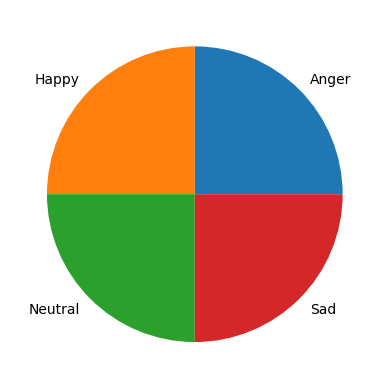

In [59]:
sum_df = new_faces_df[['pth', 'label']].groupby(['label']).count()
sum_df.rename(columns={'pth':'sum'}, inplace=True)
plt.pie(sum_df['sum'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show

## Model Setup, Training, and Evaluation

*To be followed*\
Plans:\
1 for normal model\
1 with faces split\
1 for a modified dataset with occluded body parts